In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
# testing push and pull


In [2]:
DF = pd.read_csv("dataset_world_happiness.csv")
DFcol=DF.columns
DFcol

Index(['Country', 'Region', 'Happiness Rank', 'Happiness Score',
       'GDP Per Capita', 'Family', 'Health (Life Expectancy)', 'Freedom',
       'Trust (Government Corruption)', 'Generosity', 'Dystopia Residual',
       'Year'],
      dtype='object')

In [3]:

### cleaning data set

#*********** Cleaning Country Column ***********#
mask = DF.Country.isnull()                       # Gets index of where "Country" is null == mask
DF.loc[mask, 'Country'] = DF.loc[mask,'Region']  # Inserts the value in "Region" at the same index into "Country"   

idx = DF.Country == DF.Region   # Finds index of where "Region" == "Country"
DF.loc[idx,'Region'] = np.nan   # Replaces "Region" with NaN


#************ Cleaning Region Column *************#
for i in range(len(DF['Region'])):
    
    if pd.isnull(DF.loc[i,'Region']):   # Locating cell of Null values for Region 
        country = DF.loc[i,'Country']   # stores Country of postion i 
        
        for x in range(len(DF['Country'])):
            # going through DF['Country'] until we find 'country' value and if Region is not null 
            if DF.loc[x,'Country'] == country and pd.notnull(DF.loc[x,'Region']):
                DF.loc[i,'Region'] = DF.loc[x,'Region']  # Storing Region value from postion x into position i
                break     # Breaking out of loop / ASK TA
                
indexNullRegion = DF[DF['Region'].isnull()].index.to_numpy()
NullRegion_values = ['Southeastern Asia','Eastern Asia','Sub-Saharan Africa','Latin America and Caribbean',
                    'Middle East and Northern Africa','Sub-Saharan Africa','Latin America and Caribbean',
                    'Middle East and Northern Africa','Central and Eastern Europe','Middle East and Northern Africa',
                    'Sub-Saharan Africa']
counter=0;
for i in indexNullRegion:
    if counter< 11:
        DF.loc[i,'Region'] = NullRegion_values[counter]
        counter+=1
        
#************ Cleaning Family Column ************# 

# mean for close values ; median for outliers 

RegionGrouped = DF.groupby('Region')['Family'].mean() 
# m = DF.groupby('Region')['Family'].median()
indexNullFamily = DF[DF['Family'].isnull()].index.to_numpy()

for i in indexNullFamily:
    DF.loc[i,'Family'] = RegionGrouped[DF.loc[i,'Region']]
    
#*********** Cleaning Dystopia Residual ********#

indexNullDR = DF[DF['Dystopia Residual'].isnull()].index.to_numpy()
DRmean = DF['Dystopia Residual'].mean() 
DF.loc[indexNullDR,'Dystopia Residual'] = DRmean 


In [4]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold,cross_val_score 
X = np.array(DF[['Country', 'Region', 'Happiness Rank',
       'GDP Per Capita', 'Family','Freedom',
       'Trust (Government Corruption)', 'Generosity', 'Dystopia Residual',
       'Year']])
X

array([['Switzerland', 'Western Europe', 1, ..., 0.29678000000000004,
        2.51738, 2015],
       ['Iceland', 'Western Europe', 2, ..., 0.4363, 2.70201, 2015],
       ['Denmark', 'Western Europe', 3, ..., 0.34139, 2.4920400000000003,
        2015],
       ...,
       ['Afghanistan', 'Southern Asia', 154, ..., 0.158,
        2.0922434674882893, 2019],
       ['Central African Republic', 'Sub-Saharan Africa', 155, ...,
        0.235, 2.0922434674882893, 2019],
       ['South Sudan', 'Sub-Saharan Africa', 156, ..., 0.202,
        2.0922434674882893, 2019]], dtype=object)

In [5]:
Y = np.array(DF['Happiness Score'])
Y

array([7.587     , 7.561     , 7.527     , 7.522     , 7.427     ,
       7.406     , 7.378     , 7.364     , 7.286     , 7.284     ,
       7.278     , 7.226     , 7.2       , 7.187     , 7.119     ,
       6.983     , 6.946     , 6.94      , 6.937     , 6.901     ,
       6.867     , 6.81      , 6.798     , 6.786     , 6.75      ,
       6.67      , 6.611     , 6.575     , 6.574     , 6.505     ,
       6.485     , 6.477     , 6.455     , 6.411     , 6.329     ,
       6.302     , 6.298     , 6.295     , 6.269     , 6.168     ,
       6.13      , 6.123     , 6.003     , 5.995     , 5.987     ,
       5.984     , 5.975     , 5.96      , 5.948     , 5.89      ,
       5.889     , 5.878     , 5.855     , 5.848     , 5.833     ,
       5.828     , 5.824     , 5.813     , 5.791     , 5.759     ,
       5.754     , 5.716     , 5.709     , 5.695     , 5.689     ,
       5.605     , 5.589     , 5.548     , 5.477     , 5.474     ,
       5.429     , 5.399     , 5.36      , 5.332     , 5.286  

In [6]:
def evaulate_train_test(X,Y,method,repeats):
    accs =[]
    for repeat in range(repeats):
        xtrain,xtest,ytrain,ytest=train_test_split(X,Y)
        method.fit(X,Y)
        YP=method.predict(xtest)
        accs.append(accuracy_score(ytest,YP))
    return (accs)



In [7]:
DF2019 = DF[DF['Year']==2019]
DF2019


,Country,Region,Happiness Rank,Happiness Score,GDP Per Capita,Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
605,Finland,Western Europe,1,7.769,1.340,1.244900,0.986,0.596,0.393,0.153,2.092243,2019
606,Denmark,Western Europe,2,7.600,1.383,1.244900,0.996,0.592,0.410,0.252,2.092243,2019
607,Norway,Western Europe,3,7.554,1.488,1.244900,1.028,0.603,0.341,0.271,2.092243,2019
608,Iceland,Western Europe,4,7.494,1.380,1.244900,1.026,0.591,0.118,0.354,2.092243,2019
609,Netherlands,Western Europe,5,7.488,1.396,1.244900,0.999,0.557,0.298,0.322,2.092243,2019
...,...,...,...,...,...,...,...,...,...,...,...,...
754,Rwanda,Sub-Saharan Africa,152,3.334,0.359,0.791847,0.614,0.555,0.411,0.217,2.092243,2019
755,Tanzania,Sub-Saharan Africa,153,3.231,0.476,0.791847,0.499,0.417,0.147,0.276,2.092243,2019
756,Afghanistan,Southern Asia,154,3.203,0.350,0.685964,0.361,0.000,0.025,0.158,2.092243,2019
757,Central African Republic,Sub-Saharan Africa,155,3.083,0.026,0.791847,0.105,0.225,0.035,0.235,2.092243,2019


In [8]:
DF2018 =  DF[DF['Year']==2018]
DF2018

,Country,Region,Happiness Rank,Happiness Score,GDP Per Capita,Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
456,Finland,Western Europe,1,7.632,1.305,1.244900,0.874,0.681,0.393,0.202,2.092243,2018
457,Denmark,Western Europe,3,7.555,1.351,1.244900,0.868,0.683,0.408,0.284,2.092243,2018
458,Iceland,Western Europe,4,7.495,1.343,1.244900,0.914,0.677,0.138,0.353,2.092243,2018
459,Switzerland,Western Europe,5,7.487,1.420,1.244900,0.927,0.660,0.357,0.256,2.092243,2018
460,Netherlands,Western Europe,6,7.441,1.361,1.244900,0.878,0.638,0.295,0.333,2.092243,2018
...,...,...,...,...,...,...,...,...,...,...,...,...
600,Yemen,Middle East and Northern Africa,152,3.355,0.442,0.906077,0.343,0.244,0.064,0.083,2.092243,2018
601,Tanzania,Sub-Saharan Africa,153,3.303,0.455,0.791847,0.381,0.481,0.097,0.270,2.092243,2018
602,South Sudan,Sub-Saharan Africa,154,3.254,0.337,0.791847,0.177,0.112,0.106,0.224,2.092243,2018
603,Central African Republic,Sub-Saharan Africa,155,3.083,0.024,0.791847,0.010,0.305,0.038,0.218,2.092243,2018


In [9]:
DF2017 =  DF[DF['Year']==2017]
DF2017

,Country,Region,Happiness Rank,Happiness Score,GDP Per Capita,Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
306,Norway,Western Europe,1,7.537,1.616463,1.533524,0.796667,0.635423,0.315964,0.362012,2.277027,2017
307,Denmark,Western Europe,2,7.522,1.482383,1.551122,0.792566,0.626007,0.400770,0.355280,2.313707,2017
308,Iceland,Western Europe,3,7.504,1.480633,1.610574,0.833552,0.627163,0.153527,0.475540,2.322715,2017
309,Switzerland,Western Europe,4,7.494,1.564980,1.516912,0.858131,0.620071,0.367007,0.290549,2.276716,2017
310,Finland,Western Europe,5,7.469,1.443572,1.540247,0.809158,0.617951,0.382612,0.245483,2.430182,2017
...,...,...,...,...,...,...,...,...,...,...,...,...
451,Togo,Sub-Saharan Africa,150,3.495,0.305445,0.431883,0.247106,0.380426,0.095665,0.196896,1.837229,2017
452,Rwanda,Sub-Saharan Africa,151,3.471,0.368746,0.945707,0.326425,0.581844,0.455220,0.252756,0.540061,2017
453,Tanzania,Sub-Saharan Africa,153,3.349,0.511136,1.041990,0.364509,0.390018,0.066035,0.354256,0.621130,2017
454,Burundi,Sub-Saharan Africa,154,2.905,0.091623,0.629794,0.151611,0.059901,0.084148,0.204435,1.683024,2017


In [10]:
DF2016 =  DF[DF['Year']==2016]
DF2016

,Country,Region,Happiness Rank,Happiness Score,GDP Per Capita,Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
154,Denmark,Western Europe,1,7.526,1.44178,1.16374,0.79504,0.57941,0.44453,0.36171,2.73939,2016
155,Switzerland,Western Europe,2,7.509,1.52733,1.14524,0.86303,0.58557,0.41203,0.28083,2.69463,2016
156,Iceland,Western Europe,3,7.501,1.42666,1.18326,0.86733,0.56624,0.14975,0.47678,2.83137,2016
157,Norway,Western Europe,4,7.498,1.57744,1.12690,0.79579,0.59609,0.35776,0.37895,2.66465,2016
158,Finland,Western Europe,5,7.413,1.40598,1.13464,0.81091,0.57104,0.41004,0.25492,2.82596,2016
...,...,...,...,...,...,...,...,...,...,...,...,...
301,Benin,Sub-Saharan Africa,153,3.484,0.39499,0.10419,0.21028,0.39747,0.06681,0.20180,2.10812,2016
302,Afghanistan,Southern Asia,154,3.360,0.38227,0.11037,0.17344,0.16430,0.07112,0.31268,2.14558,2016
303,Togo,Sub-Saharan Africa,155,3.303,0.28123,0.00000,0.24811,0.34678,0.11587,0.17517,2.13540,2016
304,Syria,Middle East and Northern Africa,156,3.069,0.74719,0.14866,0.62994,0.06912,0.17233,0.48397,0.81789,2016


In [11]:
DF2015 =  DF[DF['Year']==2015]
DF2015

,Country,Region,Happiness Rank,Happiness Score,GDP Per Capita,Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
0,Switzerland,Western Europe,1,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738,2015
1,Iceland,Western Europe,2,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201,2015
2,Denmark,Western Europe,3,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204,2015
3,Norway,Western Europe,4,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531,2015
4,Canada,North America,5,7.427,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176,2015
...,...,...,...,...,...,...,...,...,...,...,...,...
149,Rwanda,Sub-Saharan Africa,154,3.465,0.22208,0.77370,0.42864,0.59201,0.55191,0.22628,0.67042,2015
150,Benin,Sub-Saharan Africa,155,3.340,0.28665,0.35386,0.31910,0.48450,0.08010,0.18260,1.63328,2015
151,Syria,Middle East and Northern Africa,156,3.006,0.66320,0.47489,0.72193,0.15684,0.18906,0.47179,0.32858,2015
152,Burundi,Sub-Saharan Africa,157,2.905,0.01530,0.41587,0.22396,0.11850,0.10062,0.19727,1.83302,2015


In [12]:
DF2019.sample(20)

,Country,Region,Happiness Rank,Happiness Score,GDP Per Capita,Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
690,Algeria,Middle East and Northern Africa,88,5.211,1.002,0.906077,0.785,0.086,0.114,0.073,2.092243,2019
733,Myanmar,Southeastern Asia,131,4.360,0.710,1.008165,0.555,0.525,0.172,0.566,2.092243,2019
678,Hong Kong,Eastern Asia,76,5.430,1.438,1.090611,1.122,0.440,0.287,0.258,2.092243,2019
639,El Salvador,Latin America and Caribbean,35,6.253,0.794,1.089464,0.789,0.430,0.074,0.093,2.092243,2019
653,Ecuador,Latin America and Caribbean,50,6.028,0.912,1.089464,0.868,0.498,0.087,0.126,2.092243,2019
734,Chad,Sub-Saharan Africa,132,4.350,0.350,0.791847,0.192,0.174,0.078,0.198,2.092243,2019
610,Switzerland,Western Europe,6,7.480,1.452,1.244900,1.052,0.572,0.343,0.263,2.092243,2019
757,Central African Republic,Sub-Saharan Africa,155,3.083,0.026,0.791847,0.105,0.225,0.035,0.235,2.092243,2019
674,Libya,Middle East and Northern Africa,72,5.525,1.044,0.906077,0.673,0.416,0.152,0.133,2.092243,2019
626,Malta,Western Europe,22,6.726,1.300,1.244900,0.999,0.564,0.151,0.375,2.092243,2019


In [13]:
DF.describe()

,Happiness Rank,Happiness Score,GDP Per Capita,Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Year
count,759.000000,759.000000,759.000000,759.000000,759.000000,759.000000,758.000000,759.000000,759.000000,759.000000
mean,78.753623,5.377318,0.916629,0.989978,0.613224,0.409679,0.124838,0.216846,2.092243,2016.996047
std,45.143496,1.126170,0.407404,0.266771,0.248287,0.152673,0.104820,0.120568,0.437919,1.422115
min,1.000000,2.693000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.328580,2015.000000
25%,39.500000,4.510500,0.604024,0.791847,0.440305,0.309205,0.055000,0.129881,1.972777,2016.000000
50%,79.000000,5.314000,0.982409,1.029120,0.647380,0.431000,0.091033,0.201313,2.092243,2017.000000
75%,118.000000,6.192000,1.237500,1.162655,0.808579,0.530500,0.155225,0.275355,2.201575,2018.000000
max,158.000000,7.769000,2.096000,1.610574,1.141000,0.724000,0.551910,0.838075,3.837720,2019.000000


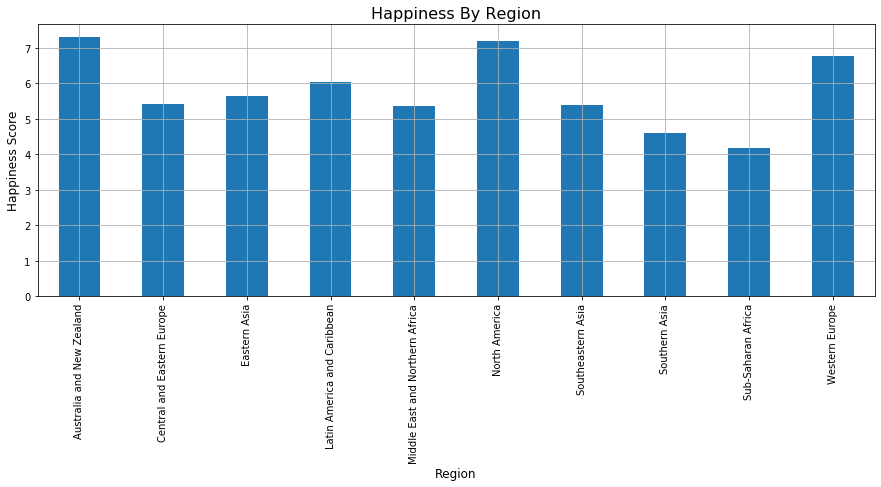

In [14]:
RegionGrouped = DF.groupby('Region')['Happiness Score'].mean()
RegionGrouped.plot.bar()
plt.title("Happiness By Region", fontsize = 16)
plt.ylabel("Happiness Score", fontsize = 12)
plt.xlabel("Region",fontsize = 12)
plt.gcf().set_size_inches(15,5)
plt.grid();


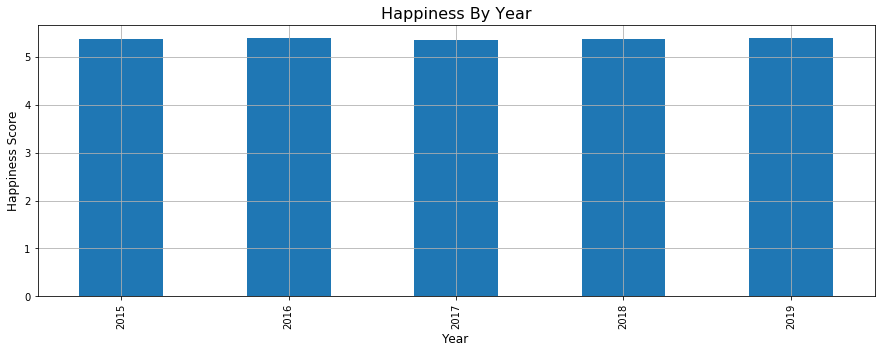

In [15]:
YearGrouped = DF.groupby('Year')['Happiness Score'].mean()
YearGrouped.plot.bar()
plt.title("Happiness By Year", fontsize = 16)
plt.ylabel("Happiness Score", fontsize = 12)
plt.xlabel("Year",fontsize = 12)
plt.gcf().set_size_inches(15,5)
plt.grid();